# CMIP6 Arctic Case Study : Show the APRP products with bar plots

--- 

## What this notebook holds :

---

### Description of the notebook

This notebook aims at showing the results of the APRP method under the form of bar plots.
More details can be found in *sw_analysis_aprp_arctic.ipynb*.

### Article we are reproducing

Zelinka, M. D., Smith, C. J., Qin, Y., and Taylor, K. E.: Comparison of methods to estimate aerosol effective radiative forcings in climate models, Atmos. Chem. Phys., 23, 8879–8898, https://doi.org/10.5194/acp-23-8879-2023, 2023.

### APRP method's reference

Taylor, K. E., M. Crucifix, P. Braconnot, C. D. Hewitt, C. Doutriaux, A. J. Broccoli, J. F. B. Mitchell, and M. J. Webb, 2007: Estimating Shortwave Radiative Forcing and Response in Climate Models. J. Climate, 20, 2530–2543, https://doi.org/10.1175/JCLI4143.1. 

### APRP module used for our analysis' reference

https://doi.org/10.5281/zenodo.5514141

### Author

Giboni Lucas, 1st year PhD Candidate at IGE (CNRS), Grenoble.

https://github.com/gibonil/gibonil

### License

Feel free to share, use and improve the following code according to the provided license on the repository.

---

# Initialisation

---

## Importations

We import the needed libraries

In [15]:
# ================ IMPORTATIONS ================ #

### LOAD AND NAVIGATE THROUGH THE DATA ###

import os  # to get access to commands related to path setting and creation of directories

### DATA OBJECTS AND ASSOCIATED COMPUTATION ###

import numpy as np  # to handle numpy arrays and the associated tools

import xarray as xr  # to manage the data

import xcdat as xc  # to handle climate model outputs with xarray

### REPRESENTING DATA ###

import matplotlib.pyplot as plt # used for makings nice plots

import matplotlib.dates as mdates # used to show months in a plot legend

import matplotlib.colors as colors # used to linearly interpolate uneven colorbars

import matplotlib.path as mpath # used to handle the polar circle

from cartopy.util import add_cyclic_point # to have nice contours plot on the earth's map

### HOMEMADE LIBRARIES ###

## Load the climatology dictionary ##

from utilities.get_cmip6_data.store_data.dict_netcdf_transform import (
    netcdf_to_dict, # to load the climatology dictionary
)  

## Handle the climatology dictionary ##

from utilities.tools_for_analysis.handle_entries.extract_entries_names import (
    get_entries_only_from_clim_dict, # to add extract the entries' names
)

## Retrieve all the entries' names without the corresponding experiment ##

from utilities.get_cmip6_data.prepare_data.extract_climatologies import (
    add_one_variable_to_dataset, # to add one variable to the full dataset
)

## Generate a common grid on which we will regrid all CMIP6 outputs ##

from utilities.tools_for_analysis.regridding.regridding_methods import(
    generate_the_common_coarse_grid, # to create the common coarse grid 
    regridding_a_dictionary, # to regrid the aprp dictionary
)

## Extract only one variant's model output ##

from utilities.tools_for_analysis.handle_entries.extract_one_variant_per_model import (
    extract_only_one_variant_keys_list, # generates the keys' list with only one variant per source id
)

## Spatial avergaes ##

from utilities.tools_for_analysis.statistical_tools.spatial_average import (
    spatial_average_given_field, # to generate the spatial average of a given field for a dataset
    adapt_full_dict_for_spatial_average, # to make sure that the datasets are ready for spatial average
)

## Generate the table ##

from utilities.representing_data.generate_tables import (
   make_full_table, # to generate the table
)

### APRP LIBRARY ###

from utilities.aprp.code.aprp import(
    APRP, # APRP method
)

### Define the paths for saving and loading data

In this part, the user needs to define the paths at which will be downloaded the data and saved the climatologies if necessary. They also need to define the path to the table associating the monthly climatologies netcdf files with their respective key in the climatologies' dictionary to be loaded. These paths are the absolute paths from the home directory.

If *get_cmip6_data.ipynb* notebook was run before, then only the path to the *key_paths_table.pkl* file is relevant here.

In [16]:
# ================ DEFINE THE FOLDERS WHERE IS STORED THE DATA ================ #

### DEFINE THE HOME DIRECTORY ###

## Home directory ##

homedir_path = os.path.expanduser("~")

### DEFINE WHERE TO DOWNLOAD THE RAW DATA ###

## Parent directory of the download folder ##

parent_path_download = homedir_path + "/certainty-data"

## Name of the download folder ##

download_folder_name = "CMIP6-DATA"

### DEFINE WHERE TO SAVE THE CLIMATOLOGIES ###

## Path of the save directory ##

parent_path_save_clim = (
    homedir_path + "/certainty-data/" + download_folder_name + "/climatologies"
)

### DEFINE WHERE TO LOOK FOR THE TABLE OF THE CLIMATOLOGIES' PATHS ###

table_path = parent_path_save_clim + "/table" + "/key_paths_table.pkl"

## Load the CMIP6 climatology

We load the CMIP6 climatology. We first check the existence of the *key_paths_table.pkl* file that indicate that the *get_cmip6_data.ipynb* notebook was successfully run. Otherwise, we launch the full routine to download the raw data and generate the climatologies. 

**This full routine lasts about 2 hours if no download was done before.**

Sometimes the data cannot be found for the downloading phase even though the entry was found in the search phase... The user will need to relaunch the code as it is an error linked to the connection to the servers.

In [17]:
# ================ LOAD THE MONTHLY CLIMATOLOGIES ================ #

### CHECK IF THE CLIMATOLOGIES WERE GENERATED BEFORE ###

if os.path.lexists(path = table_path) :

    ## The table exists we can therefore load the dictionary of the climatologies ## 

    print("The monthly climatologies were generated and can be retrieved.")

    data_cmip6_clim = netcdf_to_dict(parent_path_for_save = parent_path_save_clim)

else :

    ## The table does not exist : we need to download the data and prepare it ##

    print("No key_paths_table.pkl at the given path.\n" \
    "We download the data and create the monthly climatologies dictionary.")

    # We import the necessary submodule #

    from utilities.get_cmip6_data.prepare_data.extract_climatologies import (
    create_climatology_dict,  # to create the climatology dictionary and save it
    )

    ## Create the climatologies dictionary ##

    create_climatology_dict(
        data_path = parent_path_download,
        data_folder_name = download_folder_name,
        parent_path_for_save = parent_path_save_clim,
        selected_case = "ZELINKA-SW",
        do_we_clear = True,
        verbose = False,
    )

    ## Load it ##

    data_cmip6_clim = netcdf_to_dict(parent_path_for_save = parent_path_save_clim)

The monthly climatologies were generated and can be retrieved.


## Apply the Approximate Partial Radiative Perturbation computation to our dictionary

### Generate the APRP dictionary

Before applying the APRP function we have to be able to call both the **control** and **aer** xarray datasets for a given entry. This is why we start by generating the list of the dictionary keys without the experiments.

In [18]:
# ================ GET THE KEYS WITHOUT THE EXPERIMENT REFERENCE ================ #

### GENERATE THE KEYS WITHOUT THE EXPERIMENT ###

## Copy the list of the keys of the clim dictionary ##

clim_keys = list(data_cmip6_clim.keys())

## Generate the unique list of keys without the reference to the experiments ##

clim_keys_without_exp = [
    get_entries_only_from_clim_dict(key_with_exp) for key_with_exp in clim_keys
]

We apply the APRP method.

In [19]:
dict_aprp = {}

for key in clim_keys_without_exp:

    key_control = key + ".piClim-control"

    key_aer = key + ".piClim-aer"

    data_cmip6_clim[key_control].load()

    data_cmip6_clim[key_aer].load()

    output = APRP(data_cmip6_clim[key_control], data_cmip6_clim[key_aer])

    dict_aprp[key] = output

---

## Regrid the dictionary entries on a common coarser grid

---

### Creating a common coarser grid for all CMIP6 outputs

In order to be able to compare the different results, we wish to project them on a common map. This map needs to be coarser than all the natives grid in order to not generate false signals but still needs to be close enough to their original resolution. The solution that was found here is to generate the coarsest grid steps for latitude and longitude from the ensemble and generate a regular grid from them.

In [20]:
common_coarse_grid = generate_the_common_coarse_grid(dict_aprp)

### Regrid the entries

We now proceed to the regridding of the full dictionary.

In [21]:
### FIELDS THAT WE REGRID ###

fields_to_be_regridded = [
    'cld',
    'sfc_alb',
    'sfc_alb_clr',
    'sfc_alb_oc',
    'noncld',
    'noncld_scat',
    'noncld_abs',
    'cld_amt',
    'cld_scat',
    'cld_abs'
    ]

### REGRIDDING ROUTINE ###

dict_aprp_regridded = regridding_a_dictionary(
    fields_to_be_regridded = fields_to_be_regridded,
    output_grid = common_coarse_grid,
    dictionary_to_be_regridded = dict_aprp
)

Initialize with one variable...



Regridding all the variables...: 100%|██████████| 9/9 [01:04<00:00,  7.22s/it]


Adding areacella...

Done !


---

## Time average of the monthly climatologies 

---

In order to display one common maps per varaible we average the twelve monthly climatology maps into one.

In [22]:
### COMPUTE TIME AVERAGE ###

## Generate a dictionary of the regridded APRP maps averaged over time ##

dict_aprp_time_avg = {
    key: dict_aprp_regridded[key]
    .groupby(dict_aprp[key].time.dt.month) # we already have monthly climatologies but this way we simplify the time coordinate into into a "month" coordinate
    .mean().mean("month") # average over time
    for key in list(dict_aprp.keys())
}

---

## Generating the needed tables to plot the bar plots

---

Before making any calculation, we select only one variant per model in order to not introduce biases. 

We generate the dictionary for three regions :

* the entire world
* the Arctic (>60°)
* the Antarctic (<-60°)

In [23]:
### EXTRACT ONE KEY PER VARIANT ###

reduced_keys_list = extract_only_one_variant_keys_list(list(dict_aprp.keys()))

### GLOBAL ###

dict_aprp_time_avg_reduced_restworld = {
    key: dict_aprp_time_avg[key].sel(lat = slice(-60,60))
    for key in reduced_keys_list
}

### ARCTIC ###

dict_aprp_time_avg_reduced_arctic = {
    key: dict_aprp_time_avg[key].sel(lat = slice(60,90))
    for key in reduced_keys_list
}

### ANTARCTIC ###

dict_aprp_time_avg_reduced_antarctic = {
    key: dict_aprp_time_avg[key].sel(lat = slice(-90,-60))
    for key in reduced_keys_list
}


We then generate a pandas table holding all the variables. This is going to come handy to extract the wanted data and extract statistical properties.


In [24]:
### GLOBAL ###

full_table_restworld  = make_full_table(dataset_dictionary = dict_aprp_time_avg_reduced_restworld )

### ARCTIC ###

full_table_arctic = make_full_table(dataset_dictionary = dict_aprp_time_avg_reduced_arctic)

### ANTARCTIC ###

full_table_antarctic = make_full_table(dataset_dictionary = dict_aprp_time_avg_reduced_antarctic)


Here is one example of a generated table :

In [25]:
full_table_arctic


ARI               ACI                      \
                               scat   abs   sum  scat   abs cld_amt   sum   
ACCESS-CM2.r1i1p1f1.gn        -0.71  0.45 -0.26 -0.54  0.07   -0.27 -0.74   
ACCESS-ESM1-5.r1i1p1f1.gn     -0.11  0.49  0.38 -0.46  0.01   -0.15 -0.60   
BCC-ESM1.r1i1p1f1.gn          -0.64  0.03 -0.61 -0.81 -0.08   -0.20 -1.09   
CESM2.r1i1p1f1.gn             -0.16  0.41  0.25 -1.42  0.20   -0.15 -1.37   
CNRM-CM6-1.r1i1p1f2.gr        -0.20  0.06 -0.14 -0.33 -0.05    0.07 -0.31   
CNRM-ESM2-1.r1i1p1f2.gr       -0.17  0.14 -0.03 -0.10 -0.04   -0.00 -0.14   
CanESM5.r1i1p2f1.gn           -0.88  1.54  0.66 -0.71  0.13   -0.30 -0.88   
GFDL-CM4.r1i1p1f1.gr1         -0.59  0.66  0.07 -0.32  0.04   -0.21 -0.49   
GISS-E2-1-G.r1i1p1f1.gn       -0.73  0.10 -0.63  0.32  0.11   -0.57 -0.14   
HadGEM3-GC31-LL.r1i1p1f3.gn   -0.70  0.39 -0.31 -0.42  0.05   -0.26 -0.63   
IPSL-CM6A-LR-INCA.r1i1p1f1.gr -0.45  0.19 -0.26 -0.01 -0.06   -0.27 -0.34   
IPSL-CM6A-LR.r1i1p1f1.gr      -0.35  0.15 -0.20  0.06 -0.05    0.06  0.07   
MIROC6.r11i1p1f1.gn           -0.33 -0.01 -0.34 -0.42 -0.01   -0.11 -0.54   
MPI-ESM-1-2-HAM.r1i1p1f1.gn    0.12  0.05  0.17 -0.37  0.00   -0.16 -0.53   
MRI-ESM2-0.r1i1p1f1.gn        -0.43  0.11 -0.32 -0.52 -0.06   -0.12 -0.70   
NorESM2-LM.r1i1p1f1.gn        -0.30  0.32  0.02 -1.47 -0.07   -0.09 -1.63   
NorESM2-MM.r1i1p1f1.gn        -0.28  0.35  0.07 -1.65  0.06   -0.39 -1.98   
UKESM1-0-LL.r1i1p1f4.gn       -0.66  0.56 -0.10 -0.68  0.07   -0.30 -0.91   

                                       
                              ACI+ARI  
ACCESS-CM2.r1i1p1f1.gn          -1.00  
ACCESS-ESM1-5.r1i1p1f1.gn       -0.22  
BCC-ESM1.r1i1p1f1.gn            -1.70  
CESM2.r1i1p1f1.gn               -1.12  
CNRM-CM6-1.r1i1p1f2.gr          -0.45  
CNRM-ESM2-1.r1i1p1f2.gr         -0.17  
CanESM5.r1i1p2f1.gn             -0.22  
GFDL-CM4.r1i1p1f1.gr1           -0.42  
GISS-E2-1-G.r1i1p1f1.gn         -0.77  
HadGEM3-GC31-LL.r1i1p1f3.gn     -0.94  
IPSL-CM6A-LR-INCA.r1i1p1f1.gr   -0.60  
IPSL-CM6A-LR.r1i1p1f1.gr        -0.13  
MIROC6.r11i1p1f1.gn             -0.88  
MPI-ESM-1-2-HAM.r1i1p1f1.gn     -0.36  
MRI-ESM2-0.r1i1p1f1.gn          -1.02  
NorESM2-LM.r1i1p1f1.gn          -1.61  
NorESM2-MM.r1i1p1f1.gn          -1.91  
UKESM1-0-LL.r1i1p1f4.gn         -1.01

We extract the median and the quartiles at 5% and 95% for every column of the table. They are rounded to two decimals. The quartiles will allow us to evaluate the ensemble spread.

In [26]:
### MEDIAN ###

## Global ##

median_restworld = full_table_restworld.median(skipna = True).round(2)

## Arctic ##

median_arctic = full_table_arctic.median(skipna = True).round(2)

## Antarctic ##

median_antarctic = full_table_antarctic.median(skipna = True).round(2)

### 95% QUARTILE ###

## Global ##

quartile95_restworld = full_table_restworld.quantile(q = 0.95).round(2)

## Arctic ##

quartile95_arctic = full_table_arctic.quantile(q = 0.95).round(2)

## Antarctic ##

quartile95_antarctic = full_table_antarctic.quantile(q = 0.95).round(2)

### 5% QUARTILE ###

## Global ##

quartile5_restworld = full_table_restworld.quantile(q = 0.05).round(2)

## Arctic ##

quartile5_arctic = full_table_arctic.quantile(q = 0.05).round(2)

## Antarctic ##

quartile5_antarctic = full_table_antarctic.quantile(q = 0.05).round(2)

---

## Bar plot of the ERF for both Aerosol-Cloud and Aerosol-Radiation interactions for three different regions

---

We generate the bar plots for the three regions :

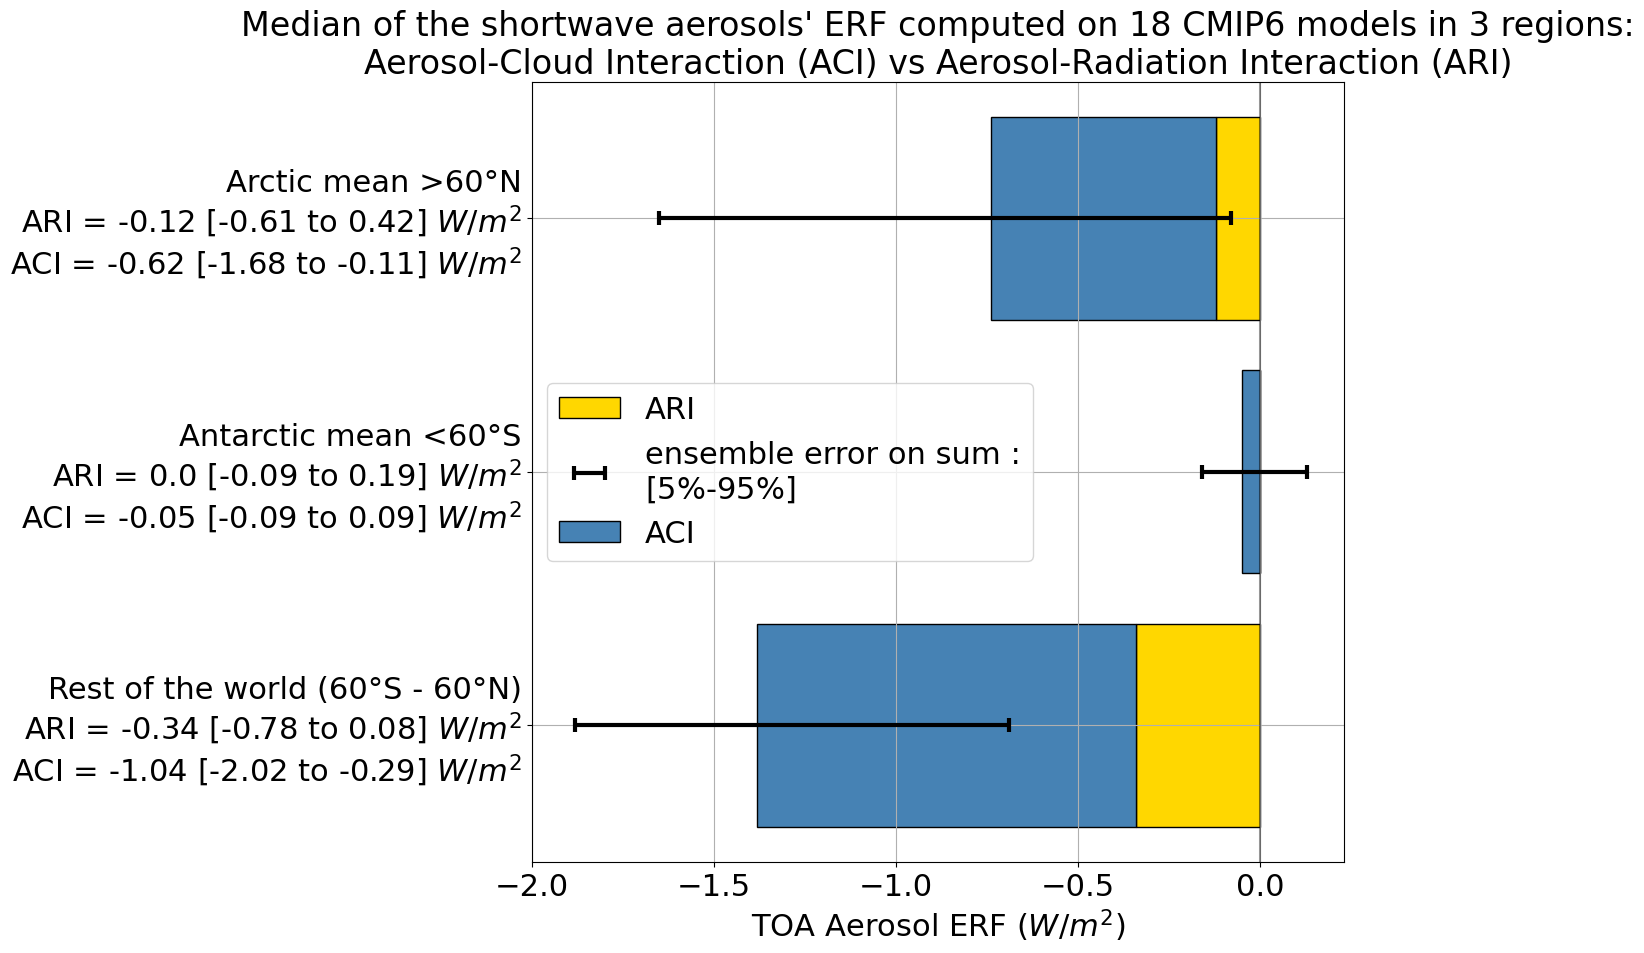

In [29]:
fig, ax = plt.subplots(figsize = (14, 10))

plt.rcParams.update({'font.size': 22})

n_models = len(reduced_keys_list)

labels = [f'Arctic mean >60°N\nARI = {median_arctic.ARI["sum"]} [{quartile5_arctic.ARI["sum"]} to {quartile95_arctic.ARI["sum"]}] $W/m^{2}$\nACI = {median_arctic.ACI["sum"]} [{quartile5_arctic.ACI["sum"]} to {quartile95_arctic.ACI["sum"]}] $W/m^{2}$', 
           f'Antarctic mean <60°S\nARI = {median_antarctic.ARI["sum"]} [{quartile5_antarctic.ARI["sum"]} to {quartile95_antarctic.ARI["sum"]}] $W/m^{2}$\nACI = {median_antarctic.ACI["sum"]} [{quartile5_antarctic.ACI["sum"]} to {quartile95_antarctic.ACI["sum"]}] $W/m^{2}$',
           f'Rest of the world (60°S - 60°N)\nARI = {median_restworld.ARI["sum"]} [{quartile5_restworld.ARI["sum"]} to {quartile95_restworld.ARI["sum"]}] $W/m^{2}$\nACI = {median_restworld.ACI["sum"]} [{quartile5_restworld.ACI["sum"]} to {quartile95_restworld.ACI["sum"]}] $W/m^{2}$']

y_pos = [1,2,3]

values_ARI = [median_arctic.ARI["sum"], median_antarctic.ARI["sum"], median_restworld.ARI["sum"]]

ax.barh(y_pos, values_ARI, align='center',color = "gold",edgecolor = 'black', capsize = 14, label = "ARI")

values_ACI = [median_arctic.ACI["sum"], median_antarctic.ACI["sum"], median_restworld.ACI["sum"]]

## [lower errors], [higher errors]

error_sum = [[np.abs(quartile5_arctic[""]["ACI+ARI"] - median_arctic[""]["ACI+ARI"]),
              np.abs(quartile5_antarctic[""]["ACI+ARI"] - median_antarctic[""]["ACI+ARI"]),
              np.abs(quartile5_restworld[""]["ACI+ARI"] - median_restworld[""]["ACI+ARI"])],
              [np.abs(quartile95_arctic[""]["ACI+ARI"] - median_arctic[""]["ACI+ARI"]),
              np.abs(quartile95_antarctic[""]["ACI+ARI"] - median_antarctic[""]["ACI+ARI"]),
              np.abs(quartile95_restworld[""]["ACI+ARI"] - median_restworld[""]["ACI+ARI"])]]
              

error_kw=dict(lw=3, capsize=5, capthick=3, label = "ensemble error on sum :\n[5$\\%$-95$\\%$]")

ax.barh(y_pos, values_ACI, xerr=error_sum, align='center',color = "steelblue",edgecolor = 'black',ecolor = 'black',capsize = 14, error_kw = error_kw, left = values_ARI, label = "ACI", )

ax.set_yticks(y_pos, labels=labels)

ax.set_xticks(np.arange(-2.0, 0.5, 0.5))

ax.tick_params(axis='both', which='major')

ax.tick_params(axis='both', which='minor')

ax.invert_yaxis()  # labels read top-to-bottom

plt.axvline(x =0, color = "k",alpha = 0.4)

ax.set_xlabel('TOA Aerosol ERF ($W/m^{2}$)')

plt.title("Median of the shortwave aerosols' ERF computed on 18 CMIP6 models in 3 regions:\nAerosol-Cloud Interaction (ACI) vs Aerosol-Radiation Interaction (ARI)", fontsize = 24)

plt.legend()

plt.tight_layout()

plt.grid()

plt.show()

---

## Bar plot of the ERF components of Aerosol-Cloud and Aerosol-Radiation interactions in the Arctic

---

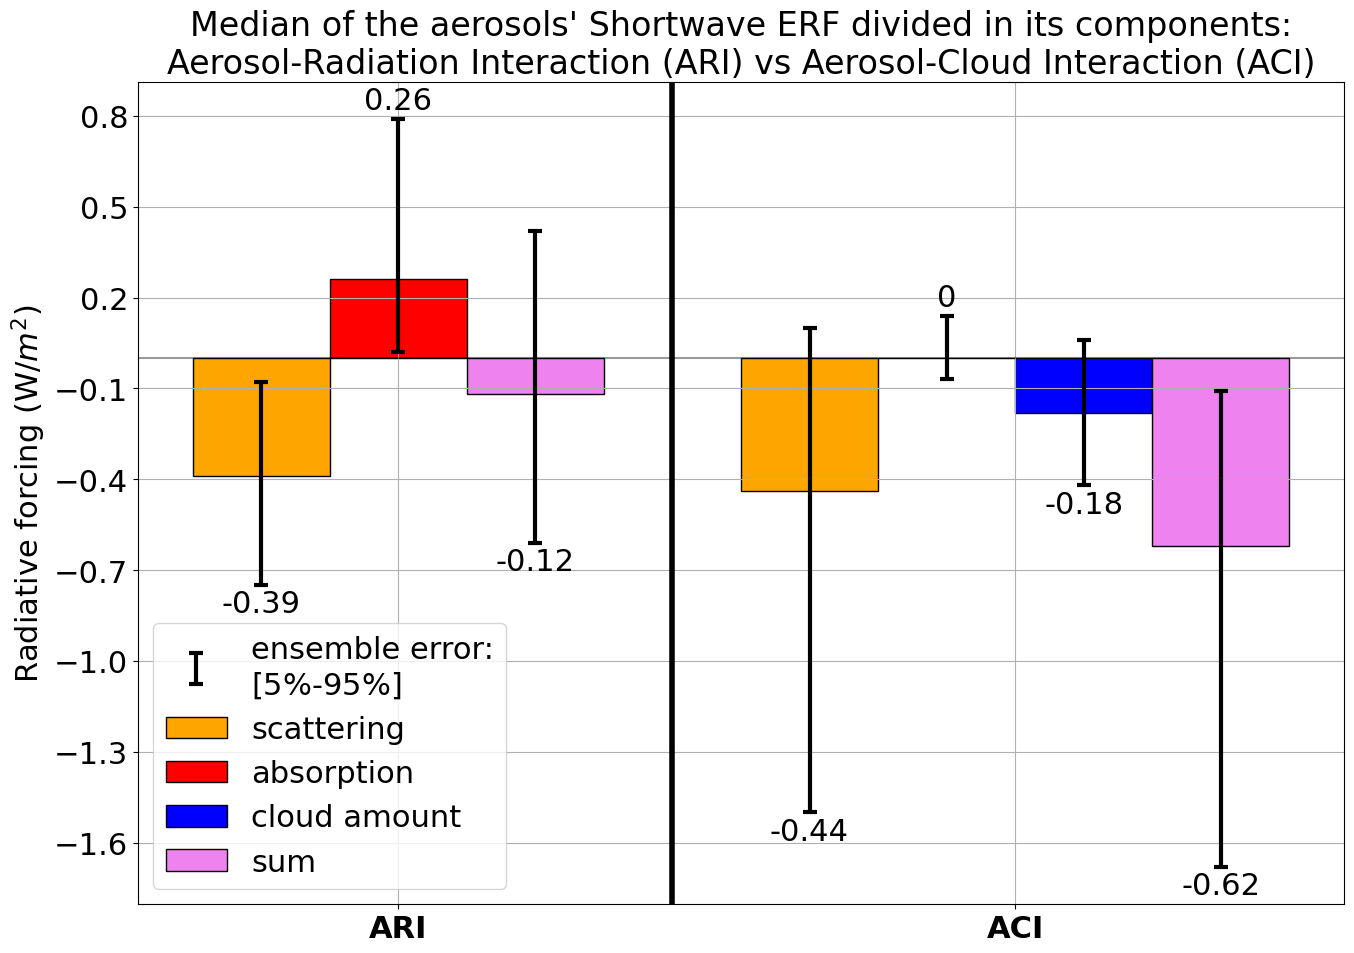

In [28]:
categories = ["ARI","ACI"]

plt.rcParams.update({'font.size': 22})


components = [["scat", "abs","sum"], ["scat", "abs","cld_amt","sum"]]

colors = ["orange", "red", "blue","violet"]
  # the label locations
width = 0.05  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize = (14, 10))


idx = 0

x = 0

labels = ["scattering", "absorption", "cloud amount","sum"]

for category in categories:

    x = x + 0.2

    interaction = median_arctic[category]

    components_given_cat = components[idx]

    idx = idx + 1

    aux_idx = 0

    multiplier = 0

    for component in components_given_cat :
        
        if category == "ARI" :

            colors = ["orange", "red", "violet"]
            
            label = '_nolegend_'

            label_error = '_nolegend_'

        else :

            colors = ["orange", "red", "blue","violet"]
            
            label = labels[aux_idx]

            if aux_idx == 0 :

                label_error =  "ensemble error:\n[5$\\%$-95$\\%$]"

            else :

                label_error = '_nolegend_'


        offset = width * multiplier

        error_kw=dict(lw=3, capsize=5, capthick=3, label =label_error)

        # yerr = [lower error, higher error]
        rects = ax.bar(x + offset, interaction[component], width = width, yerr=[[np.abs(quartile5_arctic[category][component] - median_arctic[category][component])],[np.abs(quartile95_arctic[category][component] - median_arctic[category][component])]],
                        color = colors[aux_idx], edgecolor = 'black',ecolor = 'black',capsize = 14, error_kw = error_kw, label = label)

        ax.bar_label(rects, padding=3)

        multiplier += 1

        aux_idx = aux_idx + 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Radiative forcing (W/$m^{2})$')

ax.set_title("Median of the aerosols' Shortwave ERF divided in its components:\nAerosol-Radiation Interaction (ARI) vs Aerosol-Cloud Interaction (ACI)", fontsize = 24)

ax.set_xticks([0.2 + width, 0.2*2+ 1.5*width], categories, weight = 'bold')

ax.set_yticks(np.arange(-1.6,0.9,0.3))

plt.tight_layout()

plt.axhline(y =0, color = "k",alpha = 0.4, label = '_nolegend_')

plt.axvline(x = 0.35, color = "k", alpha = 1, label = '_nolegend_', linewidth=4)

plt.legend(fontsize = 22)

plt.grid()

plt.show()